In [4]:
from pathlib import Path
from thor_scsi.factory import accelerator_from_config
from thor_scsi.pyflame import Config
import thor_scsi.lib as tslib

import numpy as np
import matplotlib.pyplot as plt

import gtpsa
import os
import time
import copy
import copy
import random


from multiprocessing import Process, Queue, Array
from queue import Empty

from scipy.stats import truncnorm, norm



prefix = Path(os.environ["HOME"])
prefix = Path("/home/al3xber")
t_dir =  prefix / "Desktop" / "Workspace"
t_file = t_dir / "BII_NLKmode_3d_start.lat"   #file provided

x_, px_ = 0, 1
y_, py_ = 2, 3

emittance_start = 70e-9
nv = 6
mo = 1
default_desc = gtpsa.desc(nv, mo)


def create_nlk_interpolation(nlk_name):
    def compute_mirror_position_plate(ref_pos, mirror_pos, *, y_plane=True):
        assert y_plane
        dy = ref_pos.imag - mirror_pos.imag
        return ref_pos - 2 * dy * 1j

    # fmt: off
    ref_pos1 =  8e-3 +  7e-3j
    ref_pos2 = 17e-3 + 15e-3j
    # fmt: on
    t_current = -7e2

    # fmt: off
    t_current *= 1 - 1 * 0.14 / 2
    ref_pos1  *= 1 - 0.14
    ref_pos2  *= 1 - 0.14

    plate_position1 = 5e-3j
    mirror_pos1 = compute_mirror_position_plate(ref_pos1, plate_position1)

    inner = tslib.aircoil_filament(ref_pos1.real, ref_pos1.imag,  t_current)
    outer = tslib.aircoil_filament(ref_pos2.real, ref_pos2.imag, -t_current)
    mirror = tslib.aircoil_filament(mirror_pos1.real, mirror_pos1.imag, -t_current * 0.14)
    nlkf_intp = tslib.NonLinearKickerInterpolation([inner, outer, mirror])

    c = Config()
    c.setAny("L", 0e0)
    c.setAny("name", nlk_name)
    c.setAny("N", 1)
    nlk = tslib.FieldKick(c)
    nlk.set_field_interpolator(nlkf_intp)
    return nlk, nlkf_intp


def create_state_space_vector(*, mu_x=0e0, mu_px=0e0, mu_y=0e0, mu_py=0e0, desc=default_desc):
    ps = gtpsa.ss_vect_double(0.0)
    ps.set_zero()
    ps.x+=mu_x
    ps.px+=mu_px
    ps.y+=mu_y
    ps.py+=mu_py
    ps.copy()
    return ps


acc = accelerator_from_config(t_file)
calc_config = tslib.ConfigType()

nlkfk = acc.find("KDNL1KR", 0)
print(nlkfk)
nlk_name = nlkfk.name
_, nlkf_intp = create_nlk_interpolation(nlk_name)

nlkfk.set_field_interpolator(nlkf_intp)

<thor_scsi::core::CellVoid const* @ 0x55b672ce1e10>(cell 201: NonLinearKicker(KDNL1KR) aperture=None observer=None)


In [6]:
from scipy.optimize import minimize

We use scipy optimise to find the kickerstrength that minimises the px value after the NLK.

Note that we did not know at this timepoint the trick shown in the thesis. Where one could use the linearity of the magnetic field strength.

In [3]:
def objective(kicker_strength, x,px,when_activate_NLK):
    #objective is to find kickerstrength that minimises px after kick

    mu_px = px
    mu_x  = x
    
    for runde in range(when_activate_NLK+1):
        if runde != when_activate_NLK:
            nlkf_intp.set_scale(0.0)
        elif runde == when_activate_NLK:
            nlkf_intp.set_scale(kicker_strength)

        ps = create_state_space_vector(mu_x=mu_x,mu_px=mu_px)
        
        if runde != when_activate_NLK:
            result = acc.propagate(calc_config, ps)
            assert result==len(acc) 

            #update mu_x and mu_px
            n_mu_x = ps.x
            n_mu_px = ps.px
            mu_x=n_mu_x
            mu_px=n_mu_px
            
        elif runde == when_activate_NLK:
            result = acc.propagate(calc_config, ps, 0,202) #propagate just until after the NLK 

            return abs(ps.px)    #return px value
        else:
            print("WHY ended here?")
        if runde !=when_activate_NLK:
            assert ps.x<=0.015

def optimal_nlk_strength(x,px,when_activate_NLK):
    res = minimize(objective,x0=np.array([0.1]),args=(x,px,when_activate_NLK),bounds = [(-1,1)])   #warum so schlechte JACOBI?!?
    return res["x"][0],res["fun"],res["success"],res

def test_optimal_nlk(x,px,when_activate_NLK):
    kicker_strength, _ = optimal_nlk_strength(x,px,when_activate_NLK)
    _,x_process,px_process,starts = single_particle(x,px,
                                        rounds_to_save = np.arange(1000),y_rounds_to_save=np.arange(1000),
                                        when_activate_NLK=when_activate_NLK,kicker_strength=kicker_strength)
    print(f"With optimal kicker strength {kicker_strength}, the electron survived {len(x_process)-1} rounds")
    return x_process,px_process

In [4]:
def run(x,px):

    mu_px = px
    mu_x  = x

    
    x_list = []
    nlkf_intp.set_scale(0.0)
    for runde in range(20):
        ps = create_state_space_vector(mu_x=mu_x,mu_px=mu_px)

        result = acc.propagate(calc_config, ps,0,201) #169?

        n_mu_x = ps.x
        n_mu_px = ps.px
        mu_x=n_mu_x
        mu_px=n_mu_px
        
        x_list.append(n_mu_x)
        
        ps = create_state_space_vector(mu_x=mu_x,mu_px=mu_px)
        
        acc.propagate(calc_config, ps, 201,len(acc)-201) #169?
        
        n_mu_x = ps.x
        n_mu_px = ps.px
        mu_x=n_mu_x
        mu_px=n_mu_px
        
        if ps.x>0.015:
            break
    return x_list

In [5]:
import tqdm
def create_plots(x_list,px_list,return_plot = True):
    extended_x_list = [x for x in x_list for i in range(len(px_list))]
    extended_px_list = np.tile(px_list,(len(x_list),))
    
    output = []
    start_list = []
    for i in tqdm.tqdm(range(len(extended_x_list))):
        #first calculate for all x values, if they fulfil the necessary condition
        
        output.append([])
        x_list2 = run(extended_x_list[i],extended_px_list[i])

        start_list.append((extended_x_list[i],extended_px_list[i]))

        for i,x in enumerate(x_list2):           #check which electrons satisfy necessary condition
            if x<0.015 and x>-0.015:
                output[-1].append(i)

        
    compatible_rounds = output
    Z1_list = []
    Z2_list = []
    for runde in range(20):
        print("--------------- RUNDE:",runde,"---------------")
        kicker_strength_list = []
        rounds_survived = []
        for i in tqdm.tqdm(range(len(extended_x_list))):
            if runde in compatible_rounds[i]:
                #if electron satifies necessary condition:
                
                #find optimal kicker strength
                kicker_strength, val, success,res = optimal_nlk_strength(extended_x_list[i],extended_px_list[i],
                                                          when_activate_NLK = runde)

                if success == False and res["message"]=="ABNORMAL_TERMINATION_IN_LNSRCH" and val<1e-8:
                    success=True

                if val >0.001:               #if it is not minimized to 0
                    success = False

                if success:
                    #now check if really 1000 rounds are survived
                    kicker_strength_list.append(kicker_strength)
                    _,x_process,_,_ = single_particle(extended_x_list[i],extended_px_list[i],
                                                rounds_to_save = np.arange(1000),y_rounds_to_save=[],
                                                when_activate_NLK=runde,kicker_strength=kicker_strength)
                    rounds_survived.append(len(x_process))
                    
                else:
                    kicker_strength_list.append(-1)
                    rounds_survived.append(-200)

                
            else:
                kicker_strength_list.append(-1)
                rounds_survived.append(-200)



        new_list = []
        for i in range(len(extended_x_list)):
            new_list.append(((rounds_survived[i],kicker_strength_list[i]), start_list[i]))

        #sort everything
        new_list.sort(key=lambda y: y[1][1])
        new_list.sort(key=lambda y: y[1][0])

        new_list = new_list[:]

        #save information in arrays
        Z1 = np.array([[new_list[j][0][0] for j in range(i*len(px_list),(i+1)*len(px_list))]
                                                                         for i in range(len(x_list))]).T
        
        Z2 = np.array([[new_list[j][0][1] for j in range(i*len(px_list),(i+1)*len(px_list))]
                                                                         for i in range(len(x_list))]).T
        Z1_list.append(Z1)
        Z2_list.append(Z2)
    
    Z1_list, Z2_list = np.array(Z1_list), np.array(Z2_list)
    np.save("Zone_array4.npy", Z1_list)
    np.save("Ztwo_array4.npy", Z2_list)
    return Z1_list,Z2_list

In [41]:
Z1_list,Z2_list = create_plots(np.linspace(15.001e-3,24e-3,60),np.linspace(-10.5e-4,17e-4,40))
np.save("Zone_array_save4.npy", Z1_list)
np.save("Ztwo_array_save4.npy", Z2_list)

  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 0 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 1 ---------------


  0%|          | 4/2400 [00:00<01:58, 20.22it/s]

--------------- RUNDE: 2 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 3 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 4 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 5 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 6 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 7 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 8 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 9 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 10 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 11 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 12 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 13 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 14 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 15 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 16 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 17 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 18 ---------------


  0%|          | 0/2400 [00:00<?, ?it/s]

--------------- RUNDE: 19 ---------------


100%|██████████| 2400/2400 [00:07<00:00, 327.12it/s]


In [10]:
Z1_list = np.load("Zone_array_save4.npy")
Z2_list = np.load("Ztwo_array_save4.npy")

In [11]:
import tqdm
def create_plots2(x_list,px_list,Z1_list,Z2_list):
    """
    function that creates the shown plots
    """
    extended_x_list = [x for x in x_list for i in range(len(px_list))]
    extended_px_list = np.tile(px_list,(len(x_list),))
    functions_list = []

    for runde in range(20):
        print("--------------- RUNDE:",runde,"---------------")
        
        x=np.unique(extended_x_list)
        y=np.unique(px_list)
        X,Y = np.meshgrid(x,y)

        Z1 = Z1_list[runde].astype(np.float)
        Z1[Z1==-200]=np.nan
        
        
        fig, ax = plt.subplots(figsize=(9,5))

        pc = ax.pcolormesh(X*1000,Y*1000,Z1,shading='auto')
        fig.colorbar(pc)

        index2 = int(runde)
        
        def format_coord(x, y,runde2 = index2):
            xarr = X[0,:]
            yarr = Y[:,0]

            if ((x > xarr.min()) & (x <= xarr.max()) & 
                (y > yarr.min()) & (y <= yarr.max())):
                col = np.searchsorted(xarr, x)-1
                row = np.searchsorted(yarr, y)-1
                z = Z1_list[runde2][row, col]
                return f'x={x:1.4f}, y={y:1.4f}, z={z:1.4f}   [{row},{col}]'
            else:
                return f'x={x:1.4f}, y={y:1.4f}'

        functions_list.append(format_coord)    
        
        ax.format_coord = functions_list[runde*2]


        plt.title(f"Amount of rounds survived using optimal Kicker_strength, Round: {runde}")
        plt.ylabel("px in mrad")
        plt.xlabel("x in mm")
        plt.show()
        
        
        
        Z2 = Z2_list[runde]
        mean_strength = np.mean(Z2[Z2>-1])
        
        
        
        fig, ax = plt.subplots(figsize=(9,5))

        pc = ax.pcolormesh(X*1000,Y*1000,Z2,shading='auto')
        fig.colorbar(pc)
        
        index2 = int(runde)
        
        def format_coord(x, y,runde2 = index2):
            xarr = X[0,:]
            yarr = Y[:,0]

            if ((x > xarr.min()) & (x <= xarr.max()) & 
                (y > yarr.min()) & (y <= yarr.max())):
                col = np.searchsorted(xarr, x)-1
                row = np.searchsorted(yarr, y)-1
                z = Z2_list[runde2][row, col]
                return f'x={x:1.4f}, y={y:1.4f}, z={z:1.4f}   [{row},{col}]'
            else:
                return f'x={x:1.4f}, y={y:1.4f}'

        functions_list.append(format_coord)    
        
        ax.format_coord = functions_list[runde*2+1]

        plt.title(f"Optimal Kicker_strength, MEAN: {mean_strength}")
        plt.ylabel("px in mrad")
        plt.xlabel("x in mm")
        plt.show()
        


--------------- RUNDE: 0 ---------------


<ipython-input-11-31ee9a81e4e0>:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Z1 = Z1_list[runde].astype(np.float)


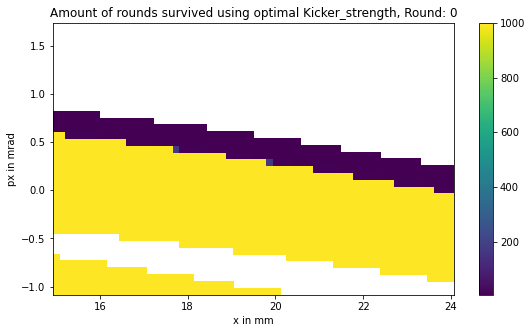

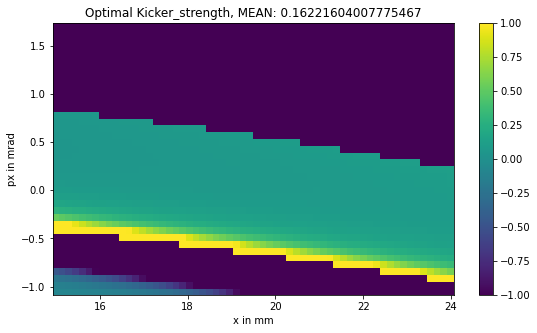

--------------- RUNDE: 1 ---------------


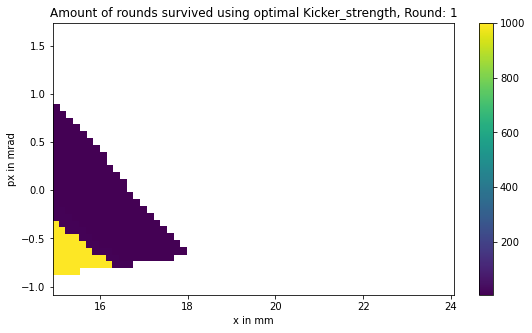

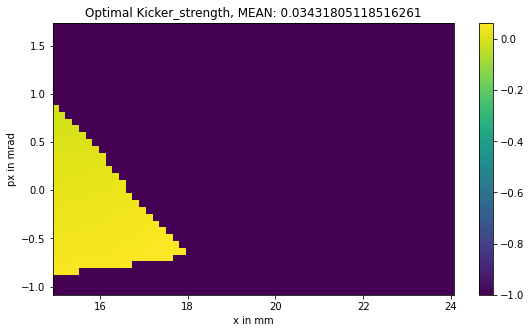

--------------- RUNDE: 2 ---------------


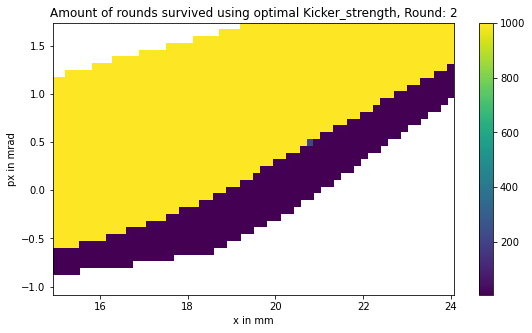

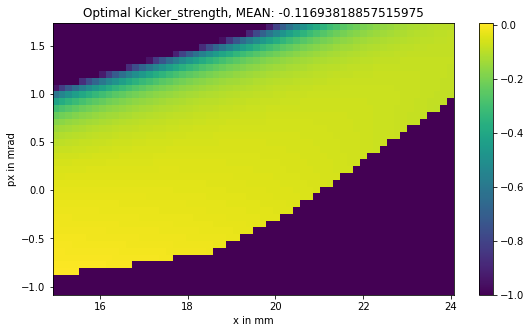

--------------- RUNDE: 3 ---------------


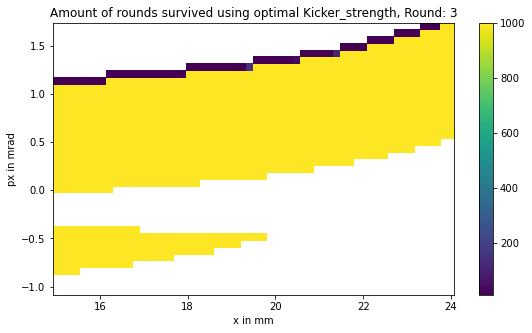

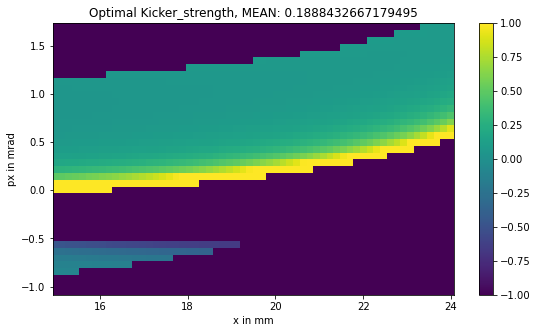

--------------- RUNDE: 4 ---------------


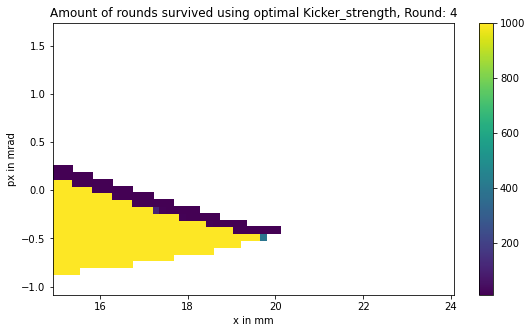

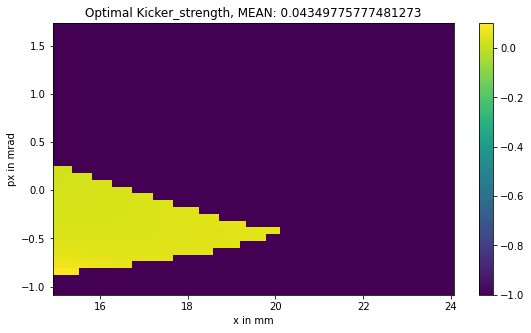

--------------- RUNDE: 5 ---------------


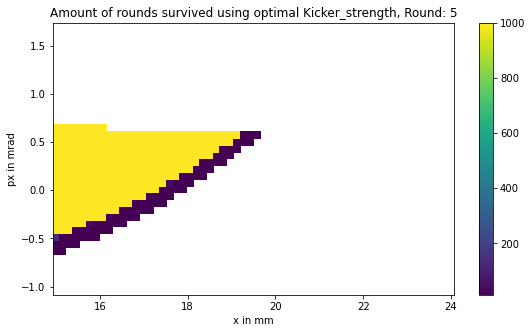

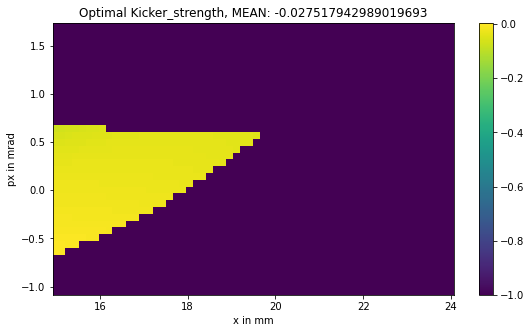

--------------- RUNDE: 6 ---------------


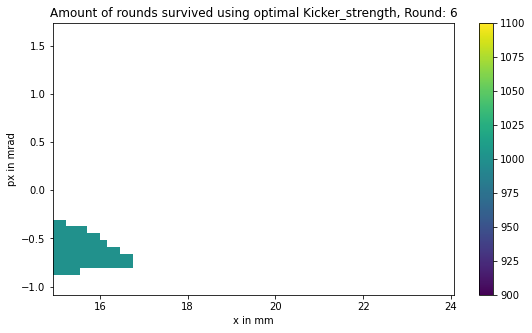

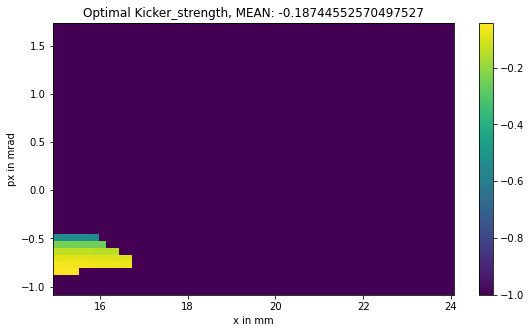

--------------- RUNDE: 7 ---------------


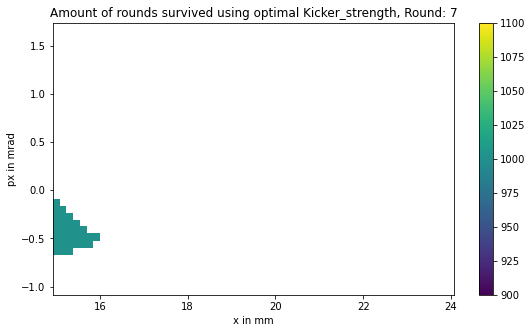

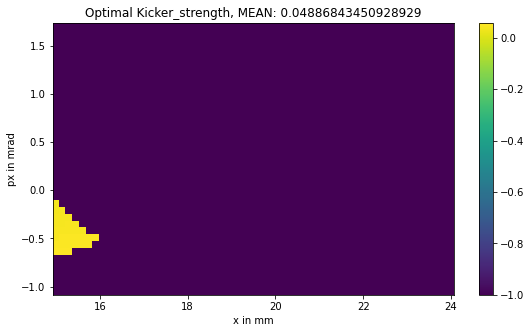

--------------- RUNDE: 8 ---------------


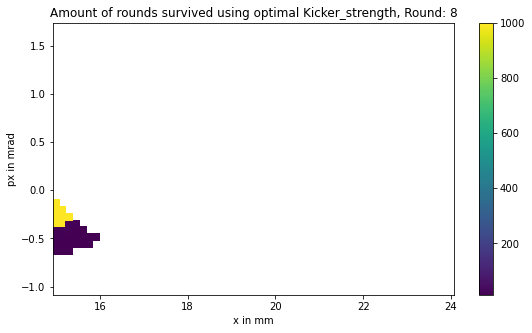

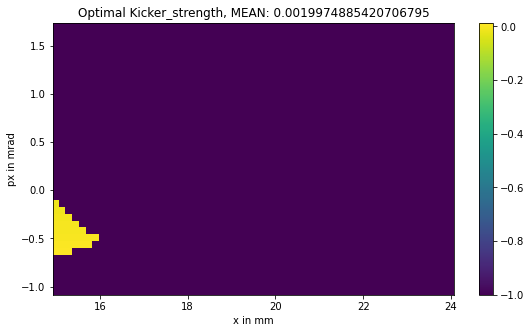

--------------- RUNDE: 9 ---------------


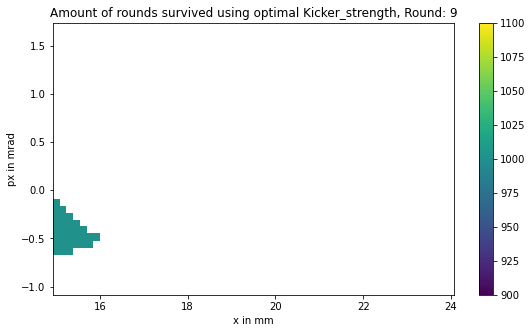

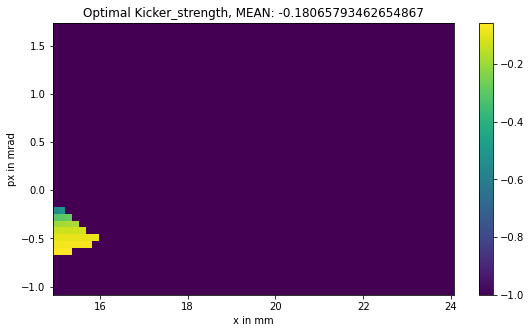

--------------- RUNDE: 10 ---------------


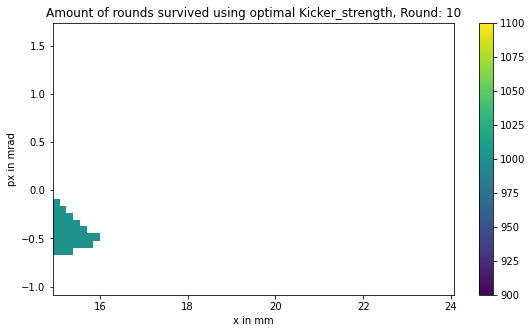

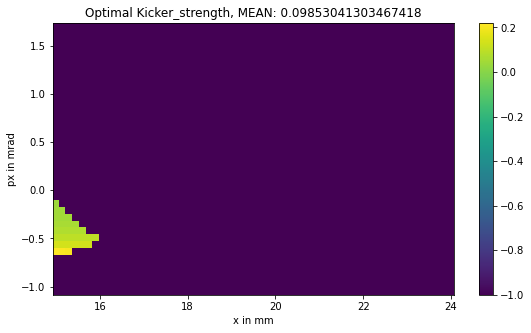

--------------- RUNDE: 11 ---------------


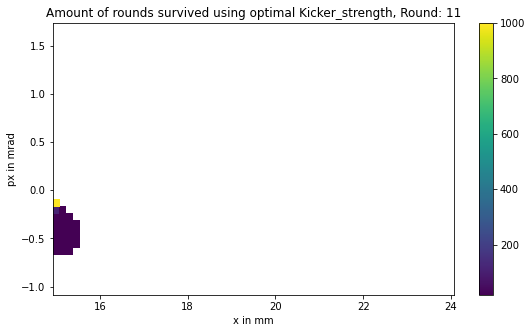

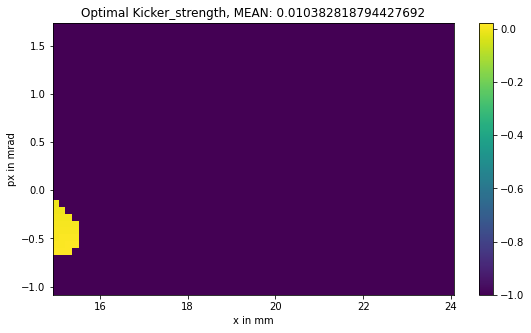

--------------- RUNDE: 12 ---------------


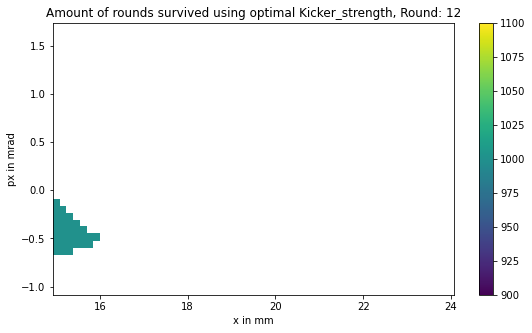

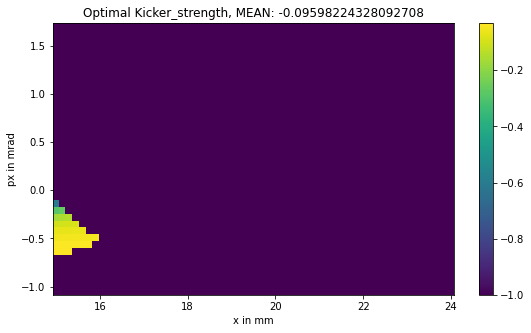

--------------- RUNDE: 13 ---------------


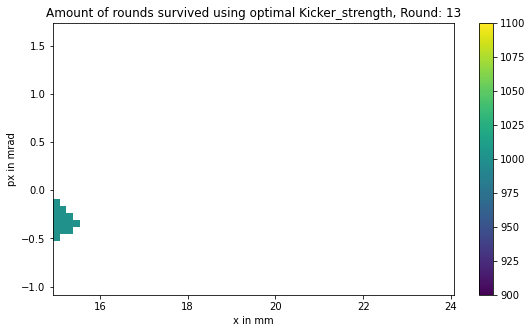

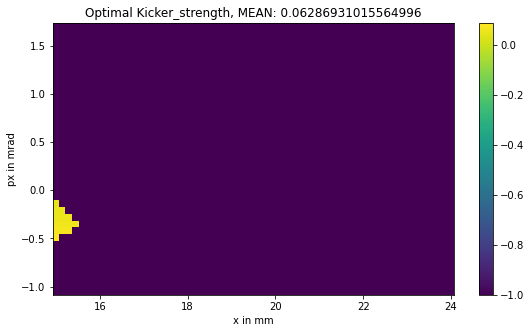

--------------- RUNDE: 14 ---------------


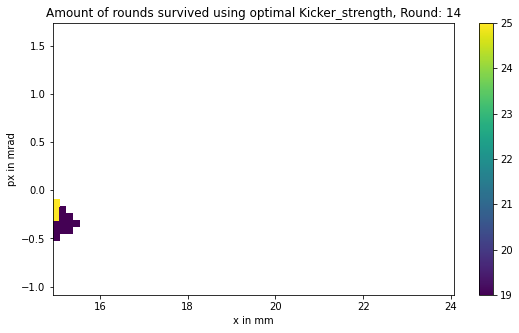

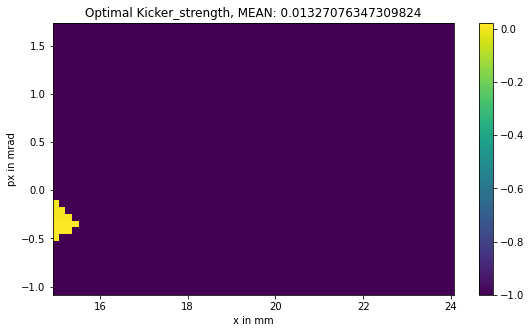

--------------- RUNDE: 15 ---------------


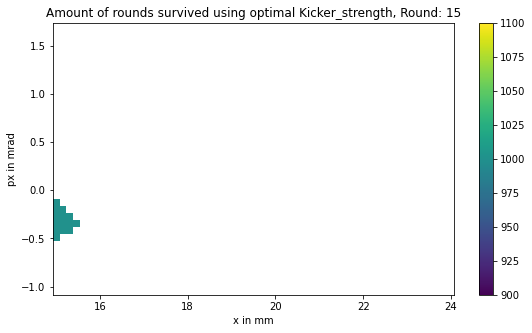

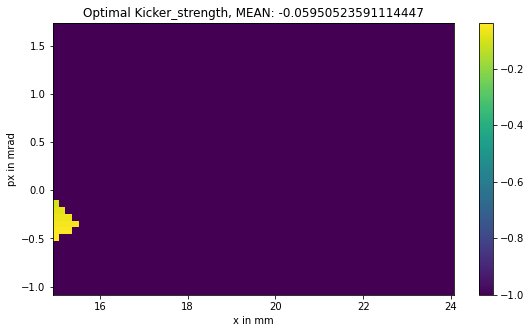

--------------- RUNDE: 16 ---------------


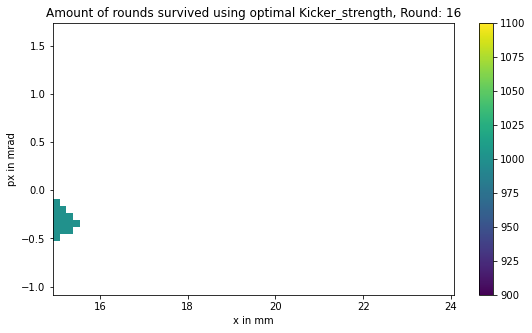

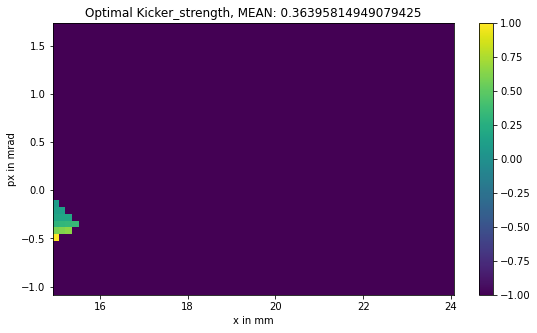

--------------- RUNDE: 17 ---------------


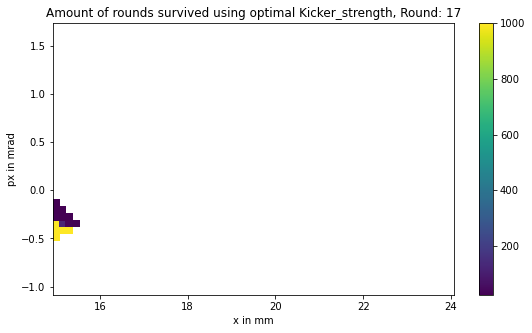

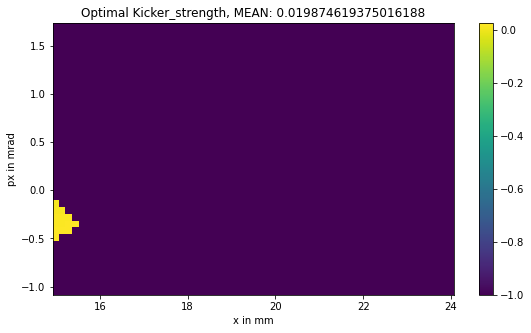

--------------- RUNDE: 18 ---------------


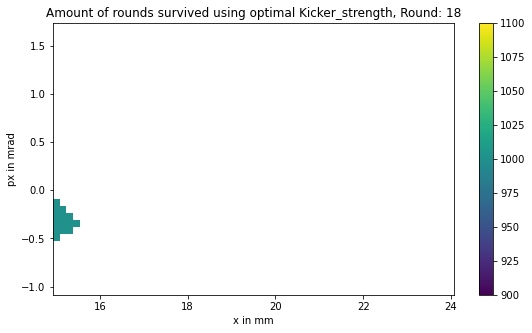

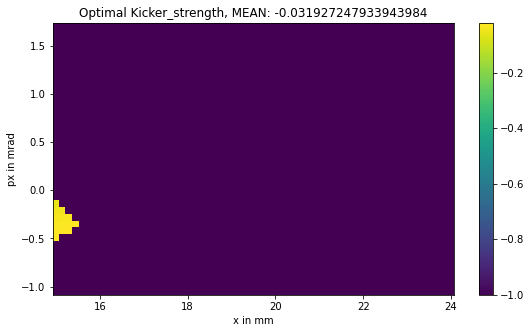

--------------- RUNDE: 19 ---------------


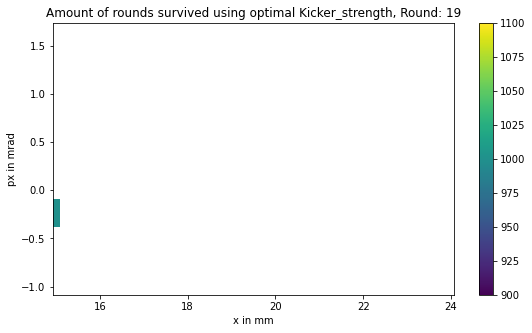

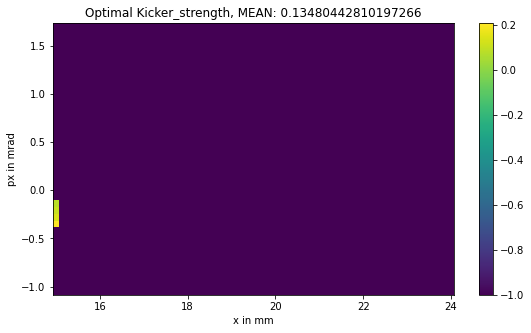

In [12]:
create_plots2(np.linspace(15.001e-3,24e-3,60),np.linspace(-10.5e-4,17e-4,40),Z1_list,Z2_list) 

Now use similar functions to create the big plots

In [6]:
import tqdm
def create_plots(x_list,px_list,return_plot = True):
    extended_x_list = [x for x in x_list for i in range(len(px_list))]
    extended_px_list = np.tile(px_list,(len(x_list),))
    
    Z1_list = []
    Z2_list = []
    start_list = []
    kicker_strength_list = []
    rounds_survived = []
    for i in tqdm.tqdm(range(len(extended_x_list))):
        start_list.append((extended_x_list[i],extended_px_list[i]))
        kicker_strength, val, success,res = optimal_nlk_strength(extended_x_list[i],extended_px_list[i],
                                                  when_activate_NLK = 0)

        if success == False and res["message"]=="ABNORMAL_TERMINATION_IN_LNSRCH" and val<1e-8:
            success=True

        if val >0.001:               #if it is not minimized to 0

            success = False

        if success:
            kicker_strength_list.append(kicker_strength)
            _,x_process,_,_ = single_particle(extended_x_list[i],extended_px_list[i],
                                        rounds_to_save = np.arange(1000),y_rounds_to_save=[],
                                        when_activate_NLK=0,kicker_strength=kicker_strength)
            rounds_survived.append(len(x_process))

        else:
            kicker_strength_list.append(-1)
            rounds_survived.append(-200)




    new_list = []
    for i in range(len(extended_x_list)):
        new_list.append(((rounds_survived[i],kicker_strength_list[i]), start_list[i]))


    new_list.sort(key=lambda y: y[1][1])
    new_list.sort(key=lambda y: y[1][0])

    new_list = new_list[:]


    Z1 = np.array([[new_list[j][0][0] for j in range(i*len(px_list),(i+1)*len(px_list))]
                                                                     for i in range(len(x_list))]).T

    Z2 = np.array([[new_list[j][0][1] for j in range(i*len(px_list),(i+1)*len(px_list))]
                                                                     for i in range(len(x_list))]).T
    Z1_list.append(Z1)
    Z2_list.append(Z2)
    
    Z1_list, Z2_list = np.array(Z1_list), np.array(Z2_list)
    np.save("Zone_array7.npy", Z1_list)
    np.save("Ztwo_array7.npy", Z2_list)
    
    return Z1_list,Z2_list

In [6]:
x_list = np.linspace(-100.0e-3,90e-3,1280)
px_list = np.linspace(-12e-3,7e-3,640)
Z1_list,Z2_list = create_plots(x_list,px_list)


100%|██████████| 819200/819200 [12:47:17<00:00, 17.79it/s]   


In [2]:
import tqdm
def create_plots2(x_list,px_list,Z1_list,Z2_list):
    extended_x_list = [x for x in x_list for i in range(len(px_list))]
    extended_px_list = np.tile(px_list,(len(x_list),))
    functions_list = []

        
    x=np.unique(extended_x_list)
    y=np.unique(px_list)
    X,Y = np.meshgrid(x,y)

    Z1 = Z1_list[0]



    fig, ax = plt.subplots(figsize=(9,5))

    pc = ax.pcolormesh(X*1000,Y*1000,Z1,shading='auto')
    fig.colorbar(pc)

    index2 = int(0)

    def format_coord(x, y,runde2 = index2):
        xarr = X[0,:]
        yarr = Y[:,0]

        if ((x > xarr.min()) & (x <= xarr.max()) & 
            (y > yarr.min()) & (y <= yarr.max())):
            col = np.searchsorted(xarr, x)-1
            row = np.searchsorted(yarr, y)-1
            z = Z1_list[runde2][row, col]
            return f'x={x:1.4f}, y={y:1.4f}, z={z:1.4f}   [{row},{col}]'
        else:
            return f'x={x:1.4f}, y={y:1.4f}'

    functions_list.append(format_coord)    

    ax.format_coord = functions_list[0*2]


    plt.title(f"Amount of rounds survived using optimal Kicker_strength")
    plt.ylabel("px in mrad")
    plt.xlabel("x in mm")
    plt.show()



    Z2 = Z2_list[0]

    mean_strength = np.mean(Z2[Z2>-1])



    fig, ax = plt.subplots(figsize=(9,5))

    pc = ax.pcolormesh(X*1000,Y*1000,Z2,shading='auto')
    fig.colorbar(pc)

    index2 = int(0)

    def format_coord(x, y,runde2 = index2):
        xarr = X[0,:]
        yarr = Y[:,0]

        if ((x > xarr.min()) & (x <= xarr.max()) & 
            (y > yarr.min()) & (y <= yarr.max())):
            col = np.searchsorted(xarr, x)-1
            row = np.searchsorted(yarr, y)-1
            z = Z2_list[runde2][row, col]
            return f'x={x:1.4f}, y={y:1.4f}, z={z:1.4f}   [{row},{col}]'
        else:
            return f'x={x:1.4f}, y={y:1.4f}'

    functions_list.append(format_coord)    

    ax.format_coord = functions_list[0*2+1]
    plt.title(f"Optimal Kicker_strength, MEAN: {mean_strength}")
    plt.ylabel("px in mrad")
    plt.xlabel("x in mm")
    plt.show()
        


In [11]:
import numpy as np
import matplotlib.pyplot as plt
Z1_list = np.load("Zone_array5.npy")
Z2_list = np.load("Ztwo_array5.npy")
x_list = np.linspace(-100.0e-3,90e-3,1280)
px_list = np.linspace(-12e-3,7e-3,640)

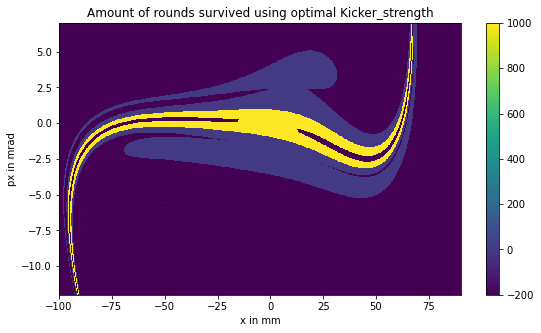

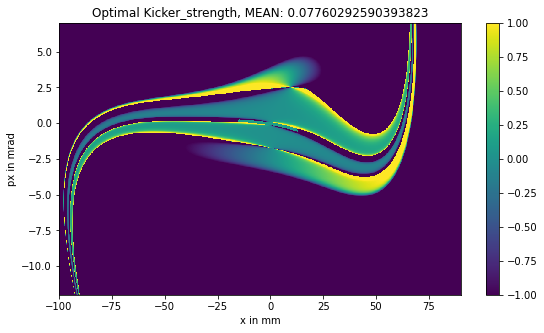

In [12]:
create_plots2(x_list,px_list,Z1_list,Z2_list)